In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import pickle

In [2]:
%matplotlib inline

In [3]:
years = ['2016', '2017', '2018', '2019', '2020']

# Creating Database

## Loading vehicle data

In [4]:
def clean_state(x):
    for char in '(1234567890)':
        x = x.replace(char,'')
    x = x.strip(' ')
    return x

traffic_dfs = {}
for year in years:
    url = "https://www.fhwa.dot.gov/policyinformation/statistics/{}/mv1.cfm".format(year)
    html = requests.get(url).content
    tempdf = pd.read_html(html)[0]
    tempdf.dropna(inplace=True)
    tempdf.columns = list(range(16))
    tempdf = tempdf[[0,3,6,9,12,15]]
    tempdf.columns = ['State', 'Automobiles_'+year, 'Buses_'+year, 'Trucks_'+year, 'Motorcycles_'+year, 'All_'+year]
    tempdf['State'] = tempdf['State'].map(clean_state)
    tempdf = tempdf[tempdf['State'] != 'Total']
    tempdf.loc[tempdf['State'] == 'Dist. of Col.', 'State'] = 'District of Columbia'
    
    traffic_dfs[year] = tempdf

In [5]:
dfs = [df.set_index('State') for df in traffic_dfs.values()]
trafficdf = pd.concat(dfs, axis=1)

In [6]:
trafficdf.head()

,Automobiles_2016,Buses_2016,Trucks_2016,Motorcycles_2016,All_2016,Automobiles_2017,Buses_2017,Trucks_2017,Motorcycles_2017,All_2017,...,Automobiles_2019,Buses_2019,Trucks_2019,Motorcycles_2019,All_2019,Automobiles_2020,Buses_2020,Trucks_2020,Motorcycles_2020,All_2020
State,,,,,,,,,,,,,,,,,,,,,
Alabama,2284443,6238,3067917,109703,5468301,2065463,5682,2872743,112185,5056073,...,2109108,5592,3065778,107730,5288208,2035376.0,5624.0,3164439.0,114901.0,5320340.0
Alaska,183259,8119,571287,31949,794614,173487,8080,591079,31859,804505,...,178516,8645,579985,28129,795275,171144.0,8620.0,586281.0,26781.0,792826.0
Arizona,2377962,9016,3233330,166583,5786891,2391624,9051,3399704,164055,5964434,...,2405959,8407,3407708,160486,5982559,2410018.0,8486.0,3514203.0,121074.0,6053781.0
Arkansas,942604,11931,1762765,90838,2808138,926789,11941,1805510,89457,2833697,...,886647,12032,1833636,169796,2902111,872437.0,12044.0,1859091.0,169797.0,2913369.0
California,14768392,98622,14511913,842106,30221033,14860967,99917,14991714,842543,30795141,...,14894912,100526,15443454,808377,31247270,14201400.0,100828.0,15310597.0,785424.0,30398249.0


## Adding Population Numbers

In [7]:
url = "https://www.infoplease.com/us/states/state-population-by-rank"
html = requests.get(url).content
tempdf = pd.read_html(html)[0][['State', '2020 Census']]

new_cols = list(tempdf.columns)
new_cols[-1] = 'Population_2020'
tempdf.columns = new_cols
tempdf = tempdf[tempdf['State'] != 'Total U.S.']
tempdf.loc[tempdf['State'] == 'DC', 'State'] = 'District of Columbia'
tempdf.set_index('State', inplace=True)


In [8]:
trafficdf = pd.concat([trafficdf, tempdf], axis=1)

## Adding Licensed Driver Numbers

In [9]:
url = "https://www.statista.com/statistics/198029/total-number-of-us-licensed-drivers-by-state/"
html = requests.get(url).content
licensedf = pd.read_html(html)[0]
licensedf.rename(columns = {'Characteristic':'State', "Number of licensed drivers":"Licensed_Drivers"}, inplace=True)
licensedf.set_index('State', inplace=True)

In [10]:
trafficdf = pd.concat([trafficdf, licensedf], axis=1)

In [11]:
trafficdf

,Automobiles_2016,Buses_2016,Trucks_2016,Motorcycles_2016,All_2016,Automobiles_2017,Buses_2017,Trucks_2017,Motorcycles_2017,All_2017,...,Trucks_2019,Motorcycles_2019,All_2019,Automobiles_2020,Buses_2020,Trucks_2020,Motorcycles_2020,All_2020,Population_2020,Licensed_Drivers
State,,,,,,,,,,,,,,,,,,,,,
Alabama,2284443,6238,3067917,109703,5468301,2065463,5682,2872743,112185,5056073,...,3065778,107730,5288208,2035376.0,5624.0,3164439.0,114901.0,5320340.0,5024279,4042900
Alaska,183259,8119,571287,31949,794614,173487,8080,591079,31859,804505,...,579985,28129,795275,171144.0,8620.0,586281.0,26781.0,792826.0,733391,518872
Arizona,2377962,9016,3233330,166583,5786891,2391624,9051,3399704,164055,5964434,...,3407708,160486,5982559,2410018.0,8486.0,3514203.0,121074.0,6053781.0,7151502,5681495
Arkansas,942604,11931,1762765,90838,2808138,926789,11941,1805510,89457,2833697,...,1833636,169796,2902111,872437.0,12044.0,1859091.0,169797.0,2913369.0,3011524,2153929
California,14768392,98622,14511913,842106,30221033,14860967,99917,14991714,842543,30795141,...,15443454,808377,31247270,14201400.0,100828.0,15310597.0,785424.0,30398249.0,39538223,27005302
Colorado,1807777,12771,3105201,190592,5116341,1785058,13305,3271595,190002,5259960,...,3471825,185875,5412404,1639028.0,13720.0,3518874.0,179086.0,5350708.0,5773714,4299447
Connecticut,1352381,12587,1390343,86531,2841842,1302339,11378,1422502,90131,2826350,...,1520176,85689,2878548,1211171.0,11773.0,1563661.0,80949.0,2867554.0,3605944,2508670
Delaware,447007,4288,524387,28158,1003840,419199,3763,519961,27810,970733,...,561323,28312,1016927,415915.0,3859.0,582338.0,4023.0,1006135.0,989948,829226
District of Columbia,206833,4682,121149,4436,337100,208141,4885,128700,4290,346016,...,136938,4351,350463,210297.0,5133.0,137540.0,3567.0,356537.0,689545,520865


## Saving Dataframe

In [13]:
trafficdf.to_pickle('Vehicle_Population_Stats.pkl')

# Analysis

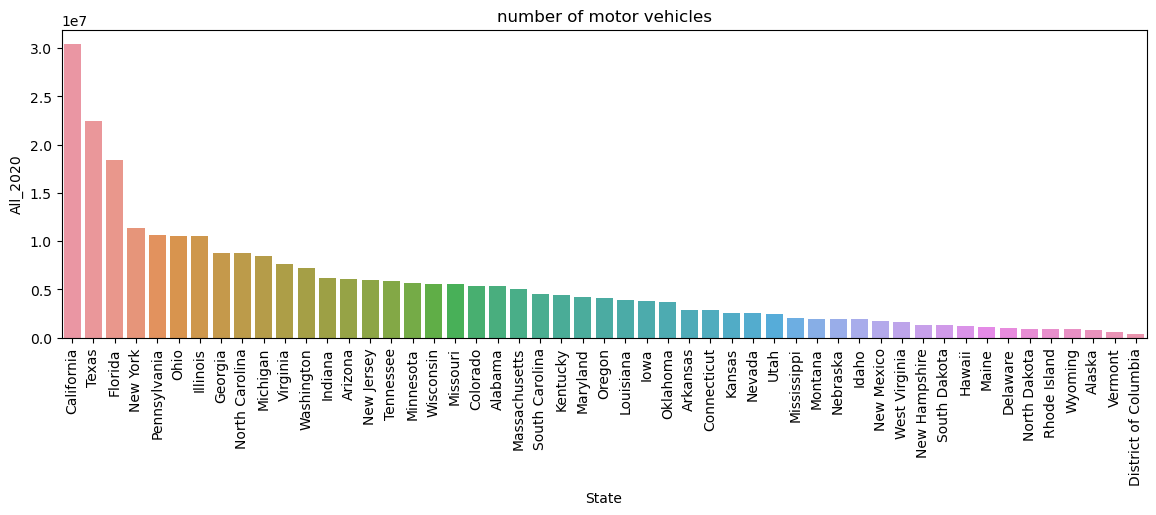

In [14]:
plt.figure(figsize=(14,4))
sns.barplot(data=trafficdf, x=trafficdf.index, y='All_2020', order=trafficdf['All_2020'].sort_values(ascending=False).index)
plt.xticks(rotation=90)
plt.title("number of motor vehicles")
plt.show()

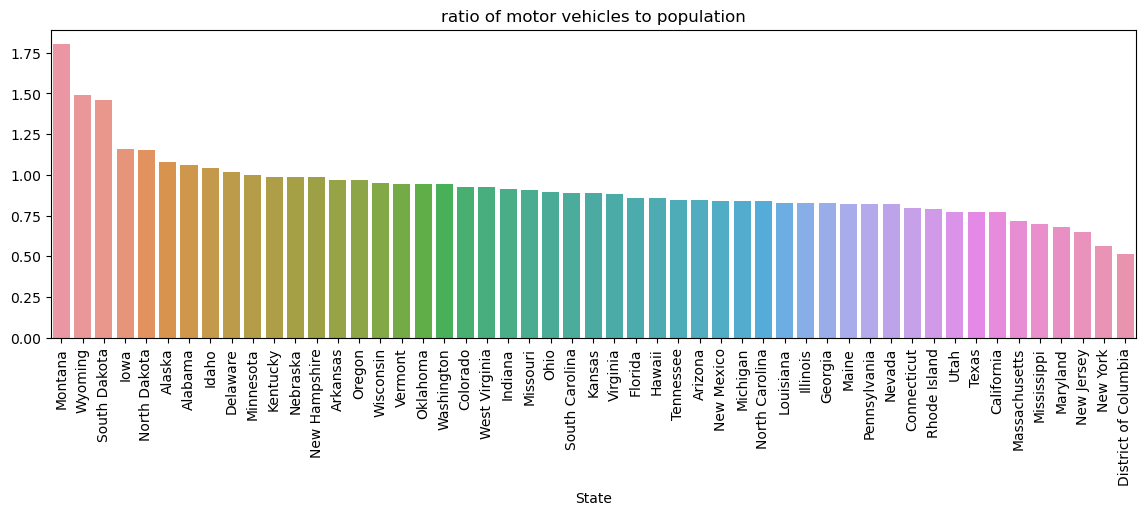

In [15]:
plt.figure(figsize=(14,4))
t_df = trafficdf['All_2020']/trafficdf['Population_2020']
sns.barplot(x=trafficdf.index, y=t_df, order=t_df.sort_values(ascending=False).index)
plt.xticks(rotation=90)
plt.title("ratio of motor vehicles to population")
plt.show()

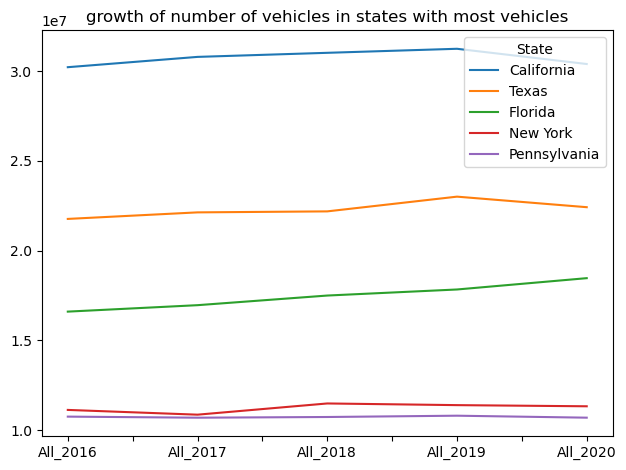

In [16]:
top5 = trafficdf['All_2020'].sort_values(ascending=False).index[:5]
trafficdf.loc[top5][['All_2016', 'All_2017', 'All_2018', 'All_2019', 'All_2020']].T.plot()
plt.title("growth of number of vehicles in states with most vehicles")
plt.tight_layout()

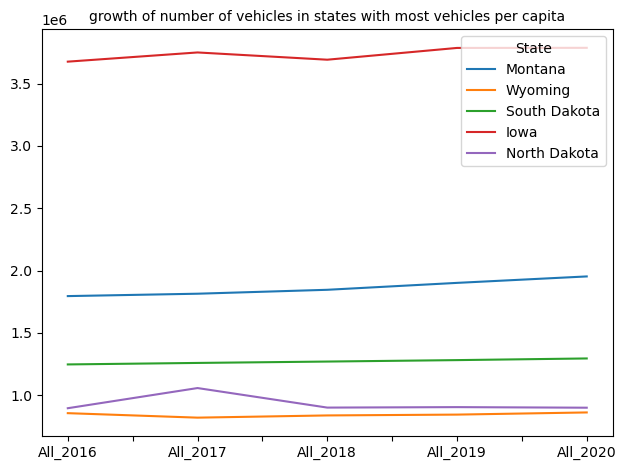

In [17]:
top5 = t_df.sort_values(ascending=False).index[:5]
trafficdf.loc[top5][['All_2016', 'All_2017', 'All_2018', 'All_2019', 'All_2020']].T.plot()
plt.title("growth of number of vehicles in states with most vehicles per capita", fontsize=10)
plt.tight_layout()

<AxesSubplot:>

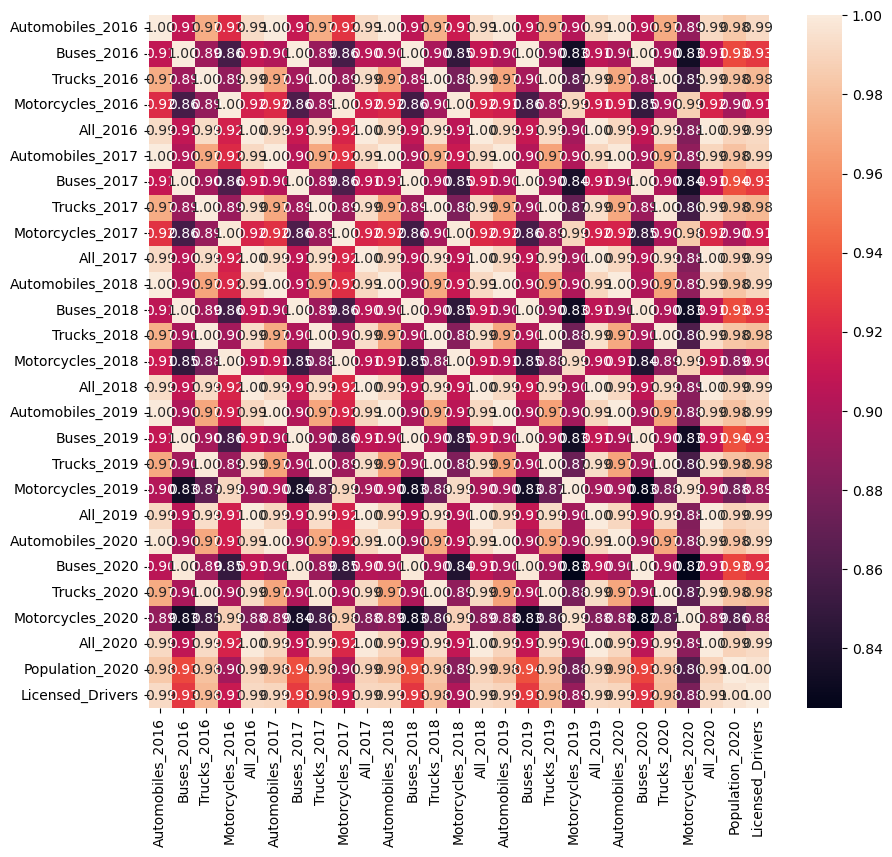

In [18]:
plt.figure(figsize=(10,9))
sns.heatmap(trafficdf.corr(), annot=True, fmt='.2f')